In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.losses import mse
from functools import partial
import keras.backend as K
import sys
from keras.datasets import mnist
import seaborn as sns
from keras.utils import plot_model

Using TensorFlow backend.


# Load dataset

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

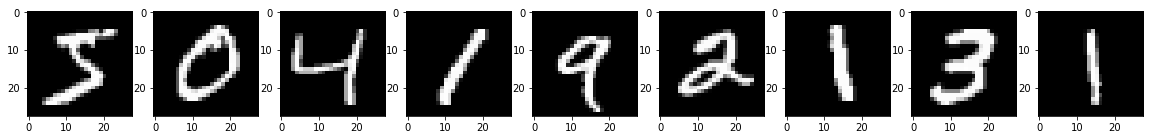

In [14]:
fig = plt.figure(figsize=(20, 15))

for i in range(9):
    plt.subplot(int(191+i))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [4]:
X_train = X_train / (255./2.) - 1.
X_test = X_test / (255./2.)   - 1.

# Build model

In [5]:
NUM_FEATURES=28
NUM_ONE_SAMPLE=28
LATENT_DIM = 2
BATCH_SIZE = 128
INTERMEDIATE_DIM = 512

In [6]:
input_shape = (NUM_ONE_SAMPLE, NUM_FEATURES, )
# VAE model = encoder + decoder
# build encoder model

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=input_shape, name='encoder_input')
x1 = Flatten()(inputs)
x2 = Dense(INTERMEDIATE_DIM, activation='relu')(x1)
z_mean = Dense(LATENT_DIM, name='z_mean')(x2)
z_log_var = Dense(LATENT_DIM, name='z_log_var')(x2)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          401920      flatten_1[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
_____________________________________

In [7]:
# build decoder model
latent_inputs = Input(shape=(LATENT_DIM,), name='z_sampling')
x3 = Dense(INTERMEDIATE_DIM, activation='relu')(latent_inputs)
x4 = Dense(NUM_FEATURES*NUM_ONE_SAMPLE, activation='tanh')(x3)
outputs = Reshape((NUM_ONE_SAMPLE, NUM_FEATURES))(x4)
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [8]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = K.sum(mse(inputs, outputs), axis=-1)
reconstruction_loss *= NUM_FEATURES*NUM_ONE_SAMPLE
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


# Train

In [9]:
epochs=10
vae.fit(X_train,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        validation_data=(X_test, None))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 26s 430us/step - loss: 5000.4325 - val_loss: 4346.0425
Epoch 2/10
60000/60000 [==============================] - 23s 381us/step - loss: 4197.0487 - val_loss: 4080.2418
Epoch 3/10
60000/60000 [==============================] - 21s 357us/step - loss: 4040.9248 - val_loss: 3991.8040
Epoch 4/10
60000/60000 [==============================] - 22s 359us/step - loss: 3955.2598 - val_loss: 3918.4347
Epoch 5/10
60000/60000 [==============================] - 23s 380us/step - loss: 3895.0057 - val_loss: 3861.1550
Epoch 6/10
60000/60000 [==============================] - 20s 340us/step - loss: 3849.7447 - val_loss: 3825.0459
Epoch 7/10
60000/60000 [==============================] - 22s 359us/step - loss: 3814.5046 - val_loss: 3800.8002
Epoch 8/10
60000/60000 [==============================] - 19s 312us/step - loss: 3784.3801 - val_loss: 3793.915

# Evaluate

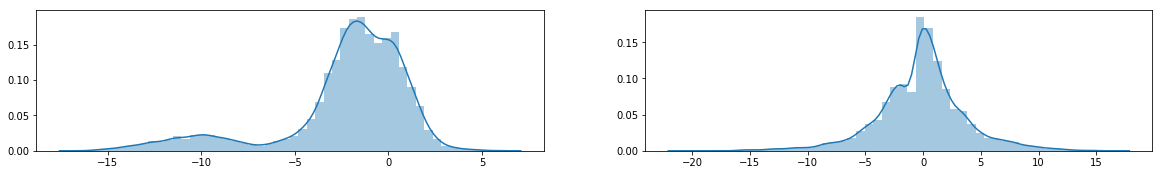

In [10]:
fig = plt.figure(figsize=(20, 15))
dist = encoder.predict(X_test)
mean = dist[0]
var = dist[1]
for i in range(LATENT_DIM):
    plt.subplot(5,2,i+1)
    sns.distplot(mean[:,i])
plt.show()

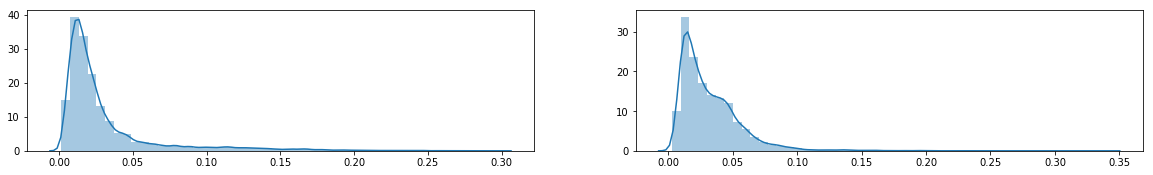

In [11]:
fig = plt.figure(figsize=(20, 15))

for i in range(LATENT_DIM):
    plt.subplot(5,2,i+1)
    sns.distplot(np.exp(0.5*var[:,i]))
plt.show()

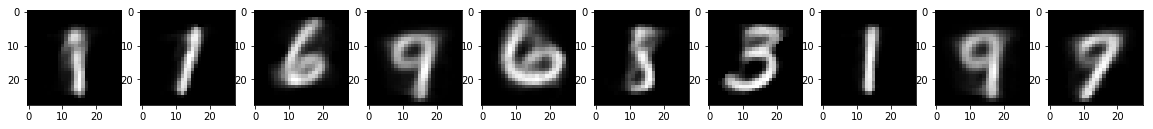

In [13]:
fig = plt.figure(figsize=(20, 15))
num_samples = 1000
idx = np.random.choice(len(mean), num_samples)

lat_ar = np.array([[np.random.normal(m, np.exp(0.5*v)) for m,v in  zip(mean[i], var[i])] for i in idx])
pred = decoder.predict(lat_ar)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(pred[i], cmap=plt.get_cmap('gray'))
plt.show()